# **Distributed Data Parallel (DDP)** using **Pytorch-lightning (pl)**

이번 자료에서는 Pytorch-lightning을 사용한 DDP 구현을 다루겠습니다.

## **DDP** 란?
Distributed-Data-Parallel (DDP) learning 이란, 기본적으로 single node 환경에서 multi-GPU 자원을 Multi process 구동을 통해 하나의 학습에 활용하는 방법입니다.

single-GPU utilization의 경우 하나의 process에서 하나의 GPU를 사용하는 방식으로 구동되는데요.

DDP의 Multi-GPU utilization은 Python muliprocessing library를 활용해 GPU 갯수만큼의 process를 initilization한 뒤 각각의 process가 한 개의 GPU를 할당받습니다. 

그 후, process 간 communication을 구현해서 각 process에서 얻을 수 있는 gradient 정보를 취합하여 사용합니다.

즉 single-GPU utilization과 DDP의 multi-GPU utilization 모두 하나의 Process 에서는 하나의 GPU를 학습에 사용하는 점은 같으나, DDP에서는 process 간 통신을 통해 각 process에서 계산한 gradient 정보를 취합해서 모델 업데이트에 사용하는 것이 차이점입니다.

**DDP**

- 모든 Process는 하나의 model parameter를 온전히 공유

- gradient backpropagation이 일어난 뒤에는 모든 process가 process 사이의 communization을 통해 gradient 정보 또한 synchronize함

### DDP Forward path

![image](https://drive.google.com/uc?export=download&id=1ZeSyBu5EOpXJgoJI2p7UIOqG280E319s)

### DDP Backward path

![image](https://drive.google.com/uc?export=download&id=1bFC8xdxFbDAUXTNuSp5PrCDaTkZSLRDZ)

### Goods
- 사용할 수 이는 GPU가 $n$개 있다고 할 때, 이상적으로는 학습 시간을 Single GPU utilization보다 $\frac {1} {n}$ 에 가깝게 줄일 수 있음

### Bads
- 서로 다른 process 간의 통신이 일어나야 하기 때문에, 각각의 GPU를 fully utilize하는 측면에서는 single GPU utilization보다는 효율이 떨어짐.
- Debugging이 어렵고 지저분해짐


## **Pytorch-lightning** 이란?

pytorch를 사용하여 코딩을 할 때 바람직한 Coding convention 이라고 할만한 형식들이 있을 수 있을 것입니다. 

Pytorch-lightning은 좋은 coding convention 을 사용하여, deep learning code를 짜는 것을 반복하는 상황에서 단순 반복성 코딩 작업을 최소화해줄 수 있는 library입니다. 

또한, 아래와 같은 여러 advanced learning optimization algorithm들에 대해 숙련된 engineer가 아니라 개념 정도를 숙지하고 있는 입문 단계 사용자들도 쉽게 접근할 수 있도록 API를 제공합니다.

- 

### Goods

- 단순 반복성 코딩 작업을 최소화
- 이미 완선된 좋은 coding convention을 유지할 수 있음 
- 검증된 코드이기 때문에 코드 개발과정에서 디버깅의 부담이 많이 경감됨
- advanced optimization algorithm들을 API를 통해 손쉽게 갖다 쓸 수 있음

### Bads

- 개별 연구에서 customization이 필요한 경우 customization하는 것은 조금 더 귀찮을 수 있음

## 왜 **DDP**를 **Pytorch-lightning**을 통해 사용하면 좋은지?

몰론 DDP를 pl을 통하지 않고 사용하는 경우도 많으며, pl은 DDP를 사용할 수 있는 방법의 하나에 불과하긴 합니다.

다만, 위에서 설명드린 것처럼 DDP 사용시 발생하는 단점들을 pl이 상쇄해줄 수 있습니다.

DDP로 코드를 확장하는 것이 귀찮고, 디버깅이 어려워지는 단점들이, pl을 통해 DDP를 사용할 경우 크게 줄어듭니다.

지금부터 아래 순서대로 Pytorch-lightning을 사용해서 DDP를 구현하는 예제를 설명드리겠습니다.

1. Pytorch-lightning 기본
2. Pytorch-lightning에서 LightningModule class 작성법
3. Pytorch-lightning에서 Trainer class 작성법
4. Pytorch-lightning 을 사용한 DDP 구동
5. Single GPU vs. DDP 의 computational time 비교


# 1. Pythorch-lightning 기본

pl은 pytorch에 대한 high-level interface라고 볼 수 있습니다.

pl의 내부 코드는 pytorch를 기반으로 작동한다는 뜻입니다.

pl을 사용하기 위해서는 아래와 같은 Core API 두 가지를 정의해줘야 합니다.

- LightningModule
- Trainer

위 두가지 클래스와, 모든 딥러닝 학습에서 본래 필요한

- Dataloader

가 준비되면, pl에서 딥러닝 학습은 대략 아래와 같은 순서대로 이루어질 수 있습니다.

1. LightingModule class를 작성하고, model instance 선언
2. Dataloader class를 작성하고, 준비된 data를 사용하여 dataloader instance 선언
3. Trainer class를 작성하고, 1, 2에서 선언한 instance를 argument로 사용하여 trainer instance 선언
4. trainer.fit()

pl을 사용하기 위해서는 LightningModule, Trainer를 어떻게 작성하는지, 어떻게 사용하는지만 유념해주시면 되겠습니다.

# 2. Pytorch-lightning에서 LightningModule class 작성법

아래는 LightningModule class를 정의하는 기본적인 방법입니다.

In [ ]:
import pytorch_lightning as pl
import torch

class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = None
        self.criterion = None

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
    
example = LitModel()

`class LitModel(pl.LightningModule):`

pl library의 LightningModule 클래스를 상속받은 자식 클래스를 작성합니다.

`self.model`

LitMoel class에서 사용할 pytorch 기반 모델을 선언합니다.

`self.criterion`

LitMoel class에서 사용할 loss function을 정의합니다.

criterion은 반드시 \_\_init\_\_ method에서 선언할 필요는 없고, loss 계산에만 쓰일 수 있으면 작동에는 문제가 없는데요.

널리 쓰이는 coding convention으로 생각해주시면 되겠습니다.

`def training_step(self, batch, batch_idx):`

주어진 batch에 대해 training phase에서 일어날 행동을 정의합니다.



이 함수에서 loss 계산이 이루어져야 model update에 gradient 정보가 반영됩니다.

`def validation_step(self, batch, batch_idx):`

주어진 batch에 대해 validation phase에서 일어날 행동을 정의합니다.

`def test_step(self, batch, batch_idx):`

주어진 batch에 대해 test phase에서 일어날 행동을 정의합니다.

`def configure_optimizers(self):`
LitModel class에서 사용한 optimization class를 반환합니다.




3. Pytorch-lightning에서 Trainer class 작성법

pl의 Trainer class에 적절한 argument를 주어 initialization하는 것으로 충분합니다.

중요한 것은 자신의 목적에 맞게 적절한 argument를 줄 수 있도록 각 argument의 의미를 이해하는 것이 되겠습니다.

In [ ]:
trainer = pl.Trainer(
    accelerator='gpu', 
    devices=[0],
    strategy='auto'
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


`accelerator`

data 및 model parameter를 계산할 accelerator를 정의합니다.

아래와 같은 accelerator를 사용 가능합니다.
- `'cpu'`
- `'gpu'`
- `'tpu'`
...


`devices`

각 accelerator 마다 사용할 하드웨어를 지정합니다.
`'gpu'`의 경우, 예시와 같이 gpu의 번호를 `list[int]` 형태로 주시면 되겠습니다.

`strategy`

적용할 학습 방법입니다.

`single gpu, ddp, deepspeed` 등의 방법들이 있는데요.

추후 `ddp`를 적용하고 싶을 때, `strategy=ddp`를 사용하면 ddp학습이 구동될 수 있습니다.

# 4. Pytorch-lightning 을 사용한 DDP 구동

CIFAR10 data, resnet50 모델을 사용한 `pl-ddp` 구동 예시를 보여드리겠습니다.

In [ ]:
# !pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
# !pip install pytorch-lightning

In [ ]:
# write pytorch-lightning model

In [ ]:
import os
import torch
import torchvision
import random
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8000

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)

# 데이터 갯수가 작아 single GPU vs. multi GPU 간 computational time 비교가 명확하지 않은 문제 때문에, 단순하게 데이터를 100배로 늘려서 사용합니다.
extended_trainset = torch.utils.data.ConcatDataset([trainset for i in range(100)])

trainloader = torch.utils.data.DataLoader(extended_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

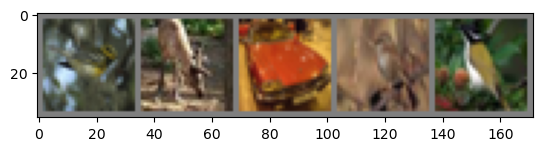

bird  deer  car   bird  bird 


In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images[:5]
labels = labels[:5]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

In [ ]:

class CIFAR10Resnet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = models.resnet50(weights=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(num_ftrs, 10) # CIFAR-10 has 10 classes

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [ ]:
model = CIFAR10Resnet()
model.model

/home/lch1492/miniconda3/envs/tut/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
trainer = pl.Trainer(
    devices=[0], 
    accelerator='cuda',
    max_epochs=1,
    min_epochs=1,
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    model=model,
    train_dataloaders=trainloader,
    val_dataloaders=testloader
    )

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/lch1492/miniconda3/envs/tut/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/lch1492/miniconda3/envs/tut/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 625/625 [06:30<00:00,  1.60it/s, v_num=33, train_loss_step=0.0046, val_loss_step=0.968, val_loss_epoch=0.977, train_loss_epoch=0.0497]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 625/625 [06:31<00:00,  1.60it/s, v_num=33, train_loss_step=0.0046, val_loss_step=0.968, val_loss_epoch=0.977, train_loss_epoch=0.0497]


single GPU 학습시, 한 에폭 당 학습시간이 `6분 30초`인 것을 확인할 수 있습니다.

# 5. Single GPU vs. DDP 의 computational time 비교

4번에서 single GPU 학습시 소요시간이 6분 30초인 것을 확인할 수 있었습니다.

위 예시에서 trainer argument만 아래처럼 바꾸면 `ddp` 구동이 가능한데요.

pl이 jupyter와 같은 interactive 환경에서 `ddp` 구동을 지원하지 않는 관계로, `ddp` 구동 시 걸린 학습 시간 이미지를 첨부하겠습니다.

![image](https://drive.google.com/uc?export=download&id=1iXBd2GhbdQmAphyBiUCHn5Q8cPK4Jht6)

위 이미지는 

- 사용 가능한 gpu (CUDA_VISIBLE_DEVICES): [0, 1, 2, 3, 4, 5, 6, 7] 총 8개 
- 실제로 사용한 gpu (LOCAL_RANK): [0, 1, 2, 3, 4, 5, 6] 총 7개

의 devices를 사용한 것인데요.

학습 시간이 `single GPU: 6분 30초 -> 7 gpu: 1분 20초` 로 줄어든 것을 확인할 수 있습니다.

학습 시간이 single GPU의 7분의 1인 로 줄었다면 1분 이내의 학습 시간을 확인할 수 있었을 것입니다.

$\frac {1} {7}$ 의 효율을 볼 수 없었던 이유는, DDP에서 multi process간 communication으로 인한 cost가 추가로 발생했기 때문인데요.

multi process communication으로 인한 약간의 손해를 감수하고서라도, 어마어마한 시간적 이득을 볼 수 있었음을 확인할 수 있습니다.